In [2]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq

%load_ext autoreload
%autoreload 2

In [3]:
adata = sc.datasets.visium_sge('V1_Breast_Cancer_Block_A_Section_1')
adata.var_names_make_unique()

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Here we do the usual preprocessing in singe cell
- remove low counts
- remove low expressed genes (We use sctm functio which just cuts off by percentage instead of exact number)
- find variable features (Personally, I found that a higher number of variable genes work better)

In [4]:
sc.pp.filter_cells(adata, min_genes=50)
sctm.pp.filter_genes(adata, 0.03,  expression_cutoff_99q = 1)
sc.pp.highly_variable_genes(adata, n_top_genes=6000, flavor="seurat_v3")

We build the graph in using squidpy's default function (Default option is the ring around each spot)

In [5]:
sq.gr.spatial_neighbors(adata)

In [6]:
n_topics = 20

In [7]:
# Only hvgs and fit a total of 15 topics
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
)

# uses gpu by default to use cpu use device="cpu"
model.train()

Computing background frequencies


/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:216: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return adj.to_sparse_csc()
Loss:6260.678:  23%|██▎       | 228/1000 [02:17<07:44,  1.66it/s]

Early Stopping


In [8]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

... storing 'feature_types' as categorical
... storing 'genome' as categorical


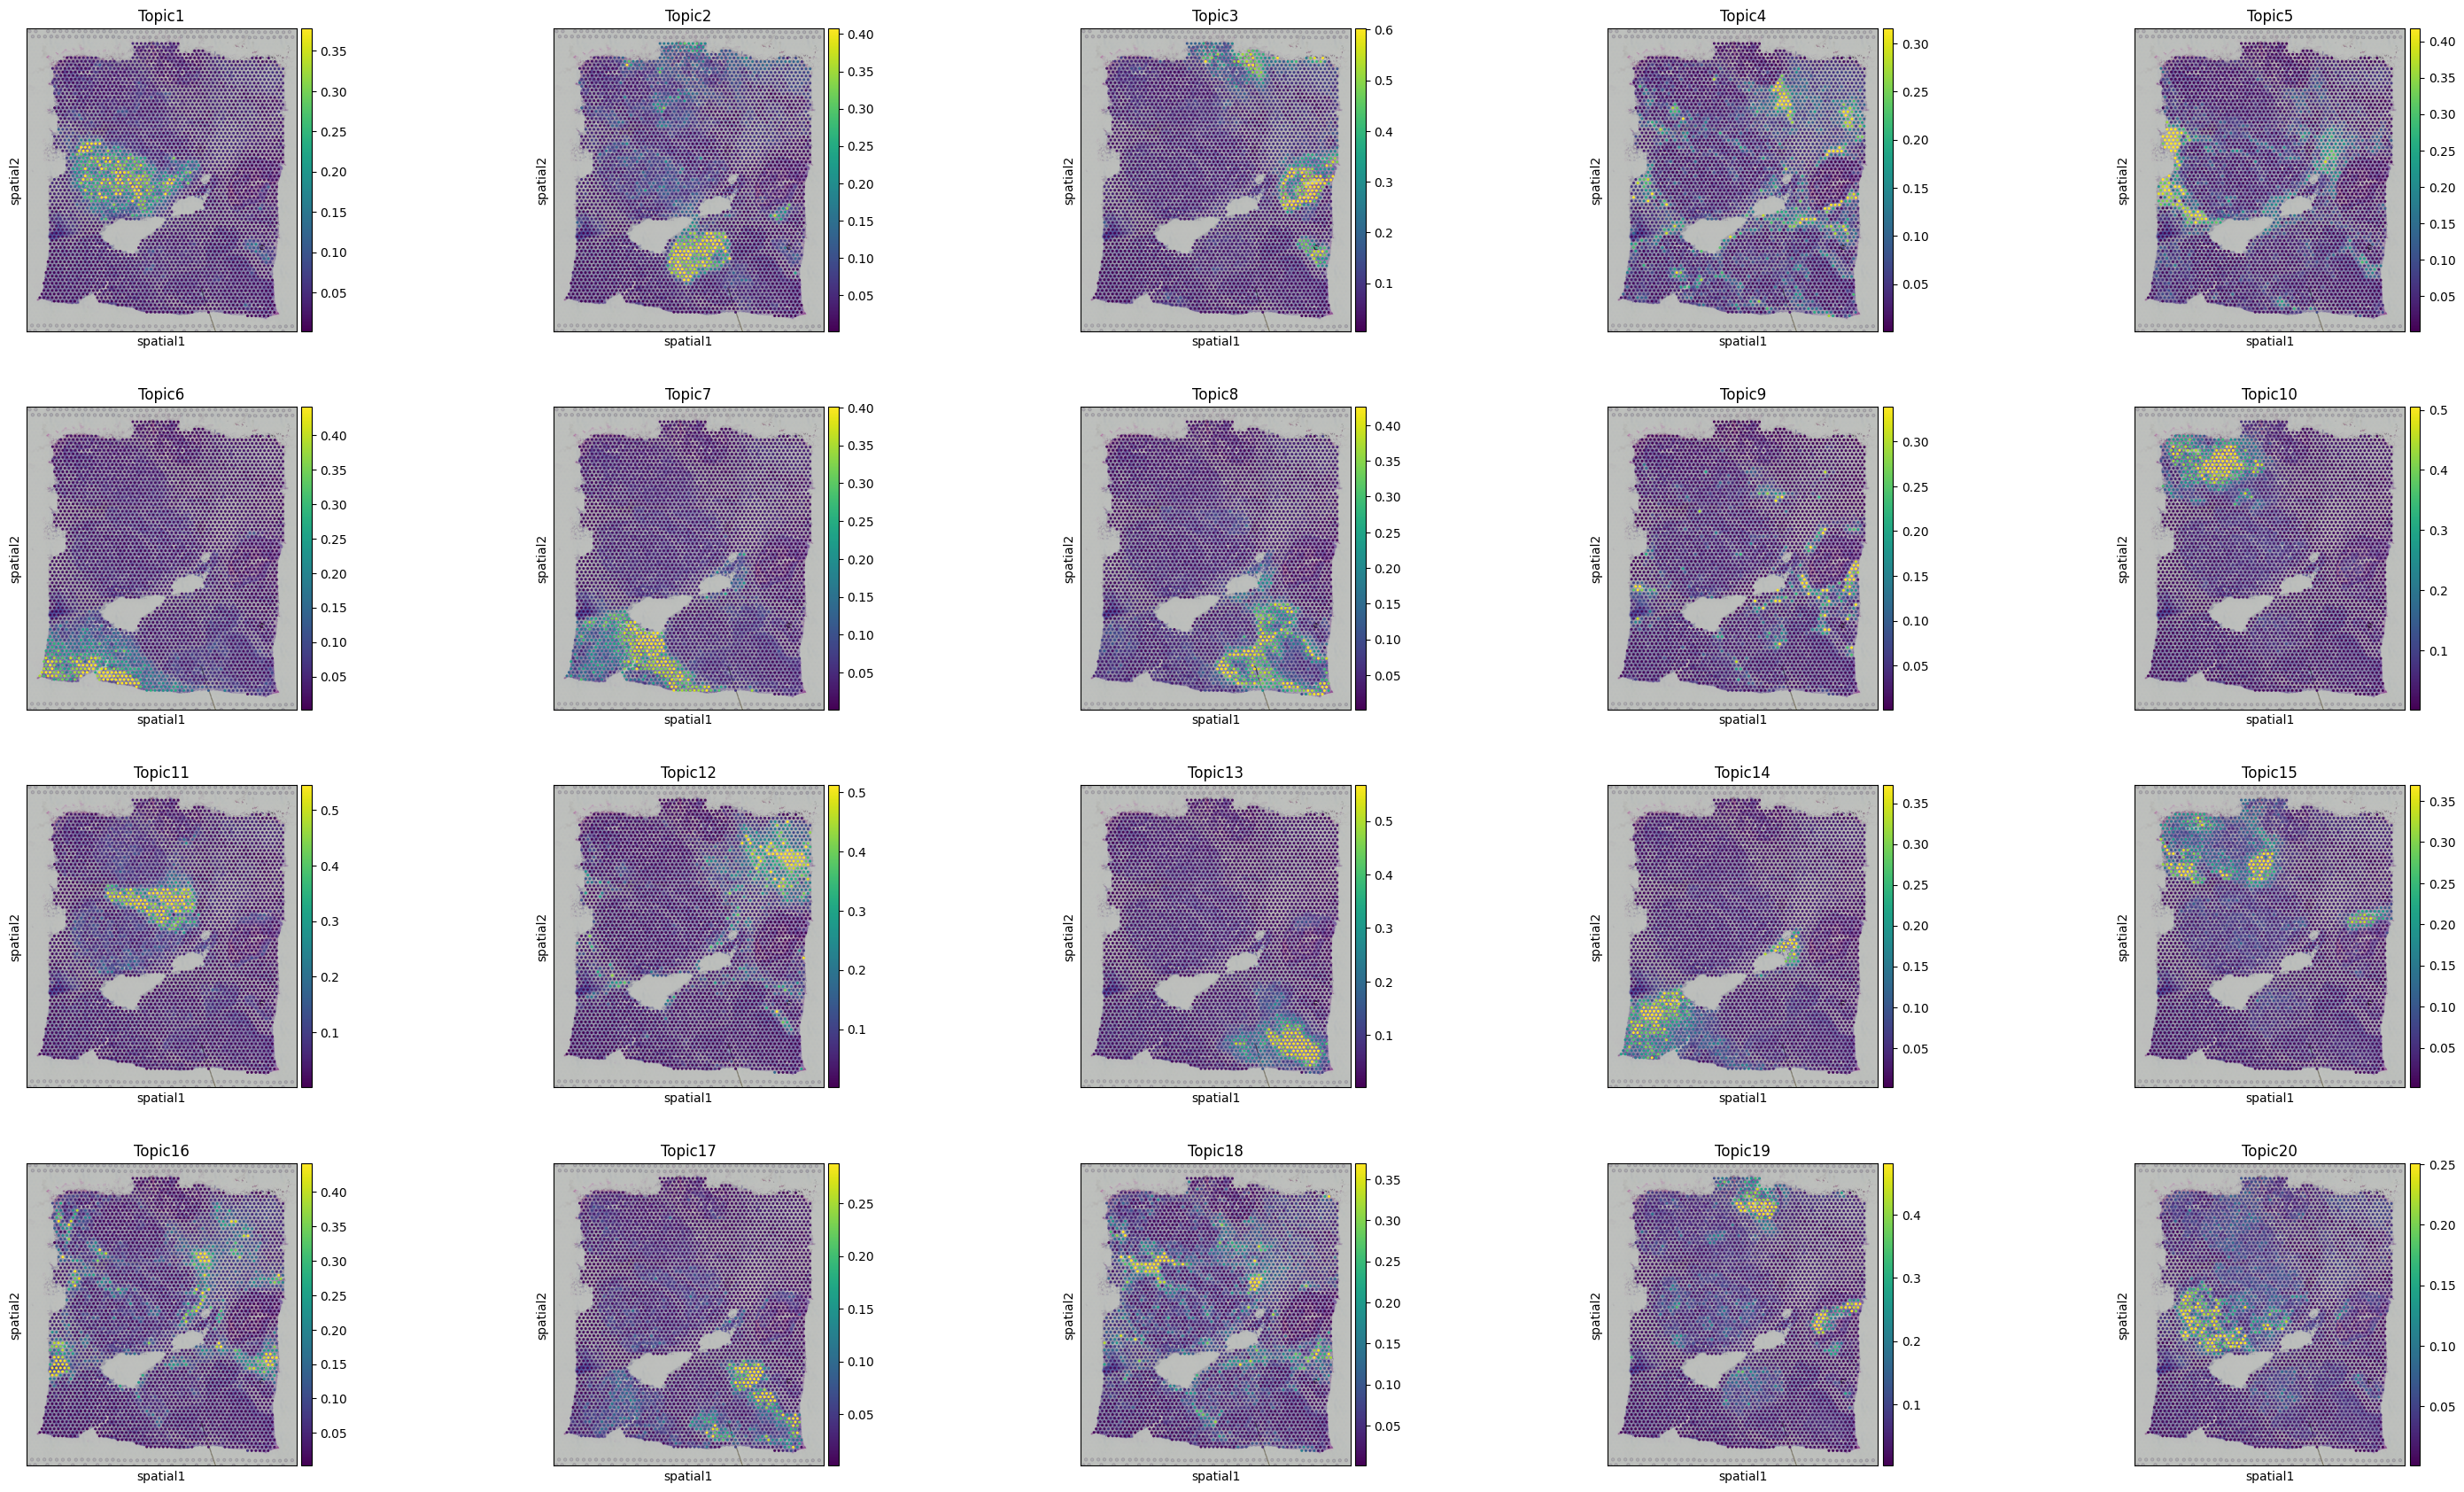

In [9]:
sc.pl.spatial(adata, color = topic_prop.columns, ncols = 5, vmax ='p99')

In [10]:
top_genes = []
for i in topic_prop.columns:
    top_genes += beta.nlargest(1, i).index.tolist()

In [13]:
sc.pl.spatial(adata, color = top_genes, vmax = 'p99', ncols = 5)

Additional plotting function(taken and editted from cell2location). On a Visium dataset, it is kinda of a marker-free deconvolution. 

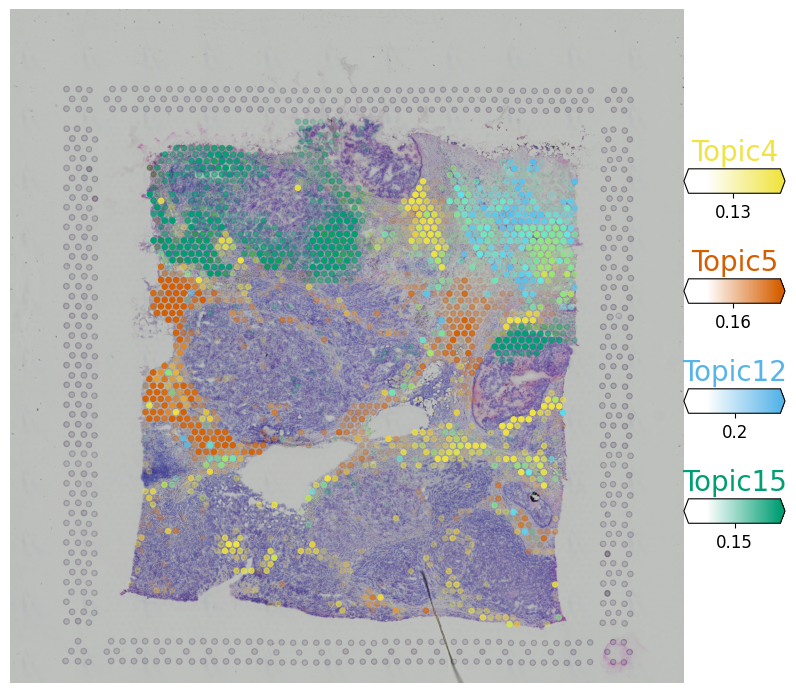

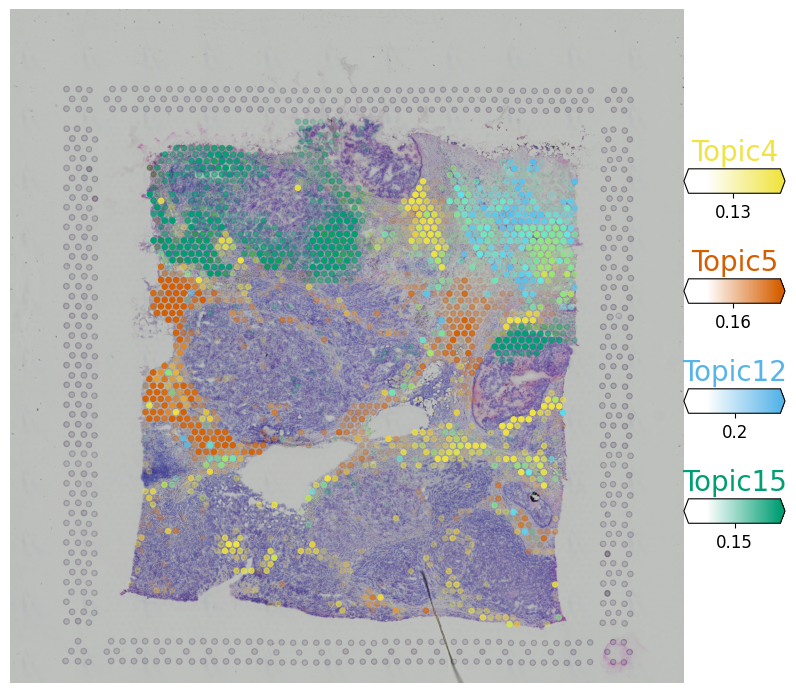

In [12]:
sctm.pl.plot_spatial(adata, topic_prop.loc[:, ["Topic4", "Topic5", "Topic12", "Topic15"]])

Annotate with DISCOtoolkit_py (only for human)

We provide a convenice function to run discotoolkit_py

In [12]:
# Annotate with DISCOtoolkit_py
#!pip install discotoolkit
disco_results = sctm.analysis.get_topic_disco(beta)

INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend Sequentia

KeyboardInterrupt: 